In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Final** **code** **for** **sentimental** **analysis** **using** **Vader** **and** **Textblob**

Data Set : IMDB and Twitter

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Twitter Data Evaluation (VADER):
Accuracy: 69.73%
Precision: 64.71%
Recall: 86.32%
F1 Score: 73.97%
Confusion Matrix:
[[19222 16875]
 [ 4902 30944]]


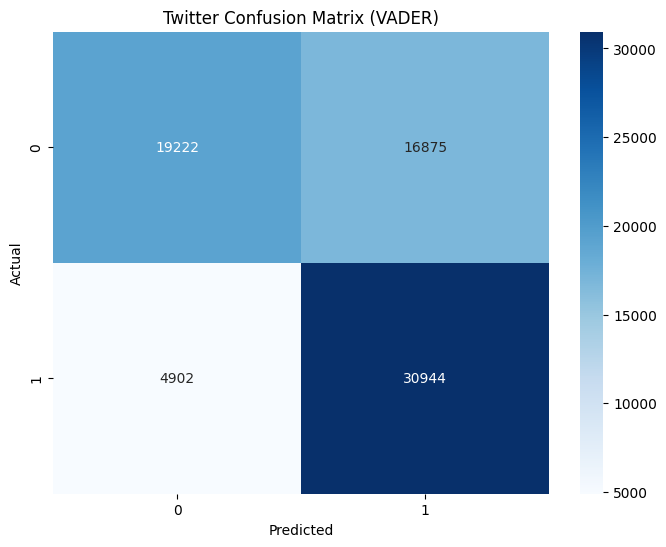


Twitter Data Evaluation (TextBlob):
Accuracy: 67.50%
Precision: 64.18%
Recall: 83.81%
F1 Score: 72.69%
Confusion Matrix:
[[15279 15212]
 [ 5266 27253]]


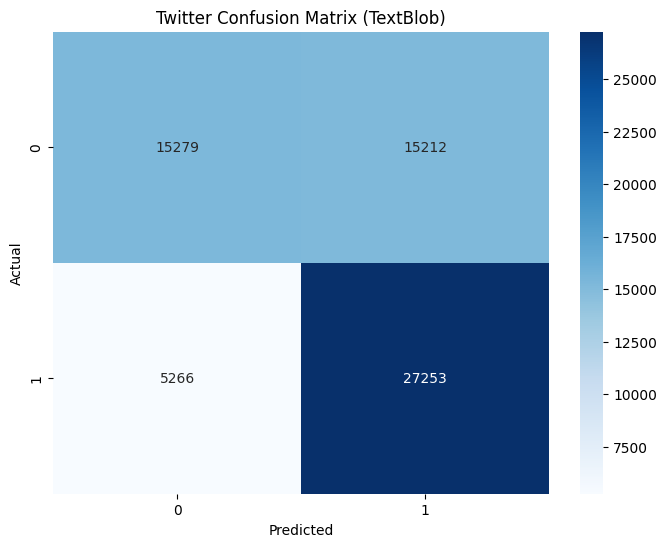


IMDB Data Evaluation (VADER):
Accuracy: 67.73%
Precision: 63.02%
Recall: 86.58%
F1 Score: 72.94%
Confusion Matrix:
[[11984 12622]
 [ 3335 21507]]


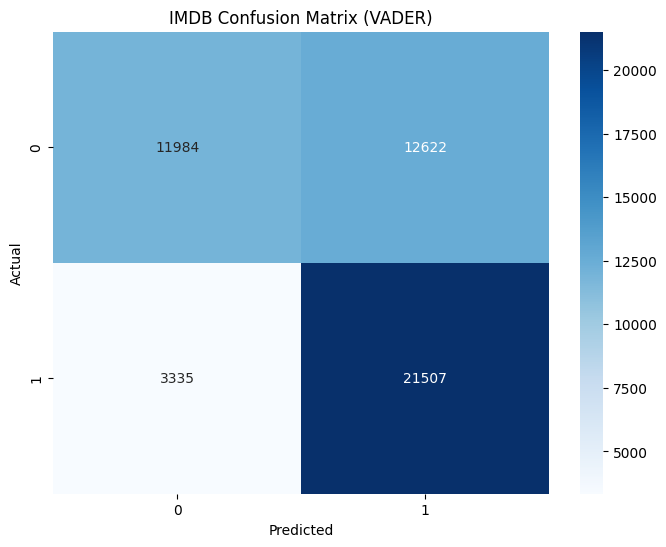


IMDB Data Evaluation (TextBlob):
Accuracy: 69.81%
Precision: 63.45%
Recall: 93.48%
F1 Score: 75.59%
Confusion Matrix:
[[11523 13454]
 [ 1629 23353]]


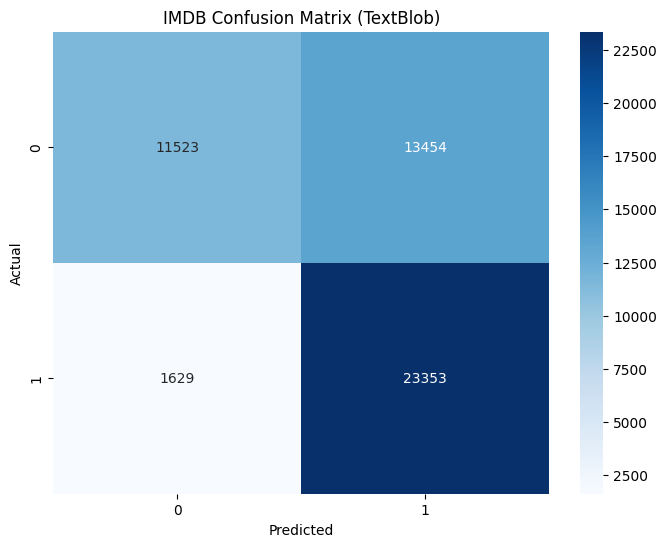

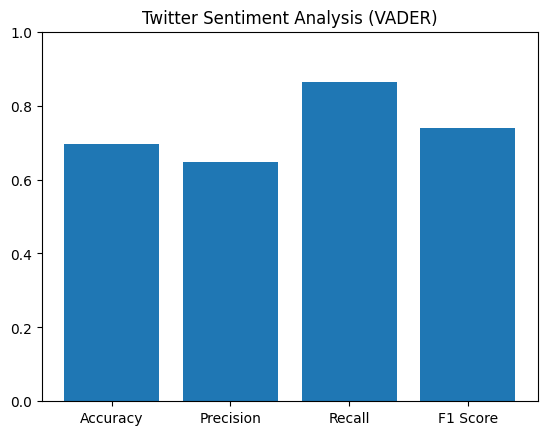

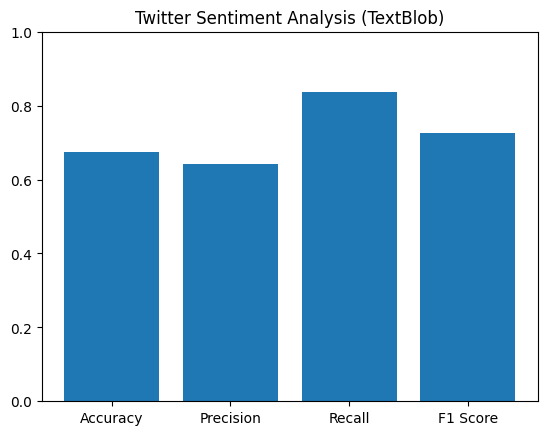

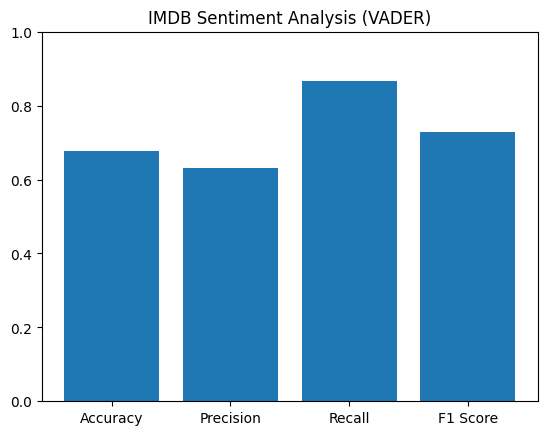

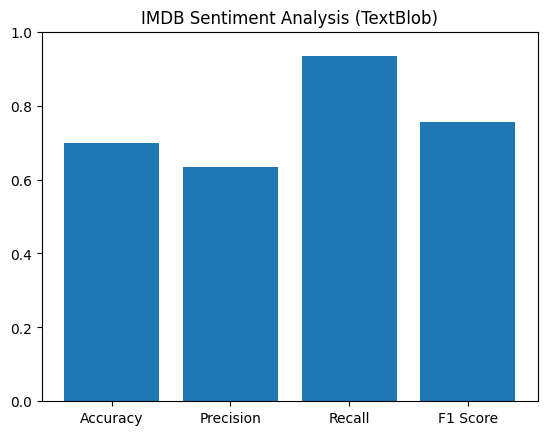

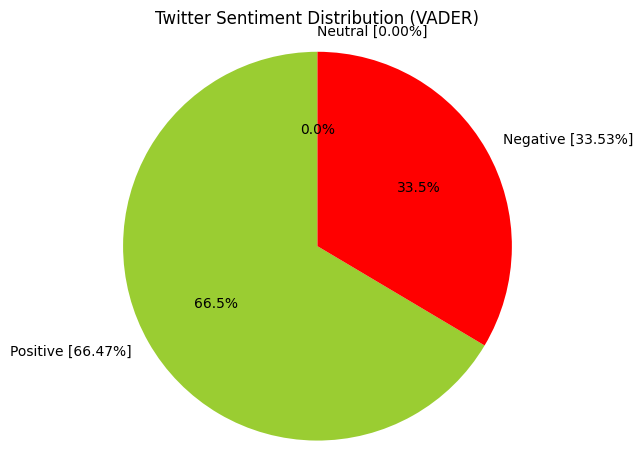

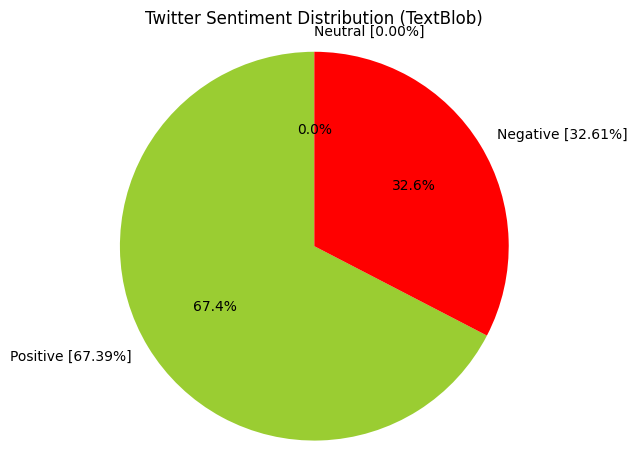

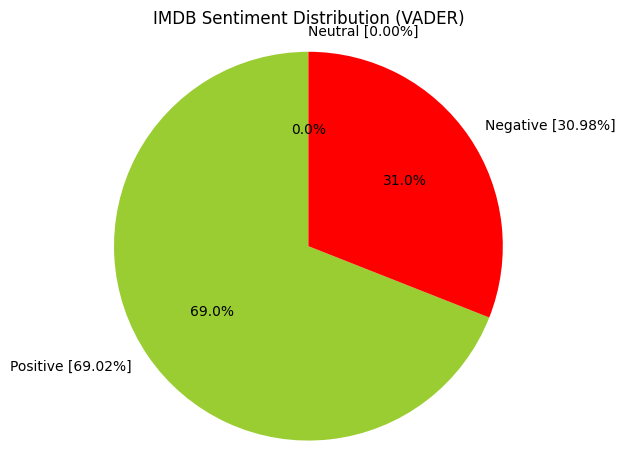

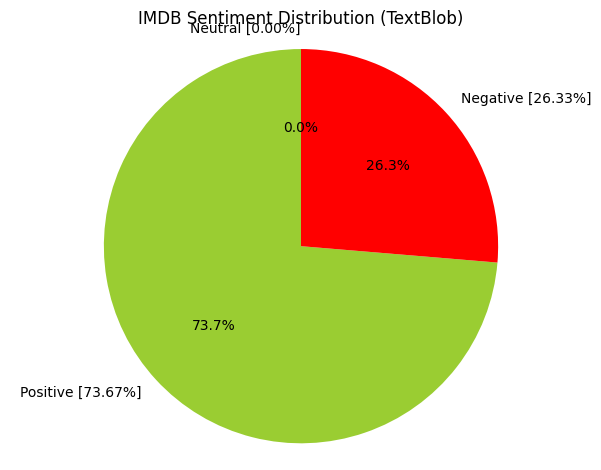

In [ ]:
import re
import nltk
import pandas as pd
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

# Download necessary NLTK resources
nltk.download("vader_lexicon")
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

# Initialize Sentiment Intensity Analyzer
sia = SentimentIntensityAnalyzer()

# Function to clean text
def clean_text(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters and digits
    tokens = nltk.word_tokenize(text)  # Tokenization
    tokens = [token.lower() for token in tokens]  # Lowercasing
    stop_words = set(nltk.corpus.stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]  # Remove stopwords
    lemmatizer = nltk.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Lemmatization
    return " ".join(tokens)  # Join tokens back into a string

# Function to calculate sentiment scores using VADER
def calculate_vader_sentiment(df, text_col):
    df["vader_compound"] = df[text_col].apply(lambda x: sia.polarity_scores(x)["compound"])
    df["vader_sentiment"] = df["vader_compound"].apply(lambda x: 1 if x >= 0.05 else (0 if x <= -0.05 else None))
    return df.dropna(subset=["vader_sentiment"])

# Function to calculate sentiment scores using TextBlob
def calculate_textblob_sentiment(df, text_col):
    df["textblob_sentiment"] = df[text_col].apply(lambda x: TextBlob(x).sentiment.polarity)
    df["textblob_sentiment"] = df["textblob_sentiment"].apply(lambda x: 1 if x > 0 else (0 if x < 0 else None))
    return df.dropna(subset=["textblob_sentiment"])

# Function to evaluate the model
def evaluate_model(df, predicted_col, target_col):
    # Convert string labels to numeric for evaluation
    label_mapping = {'positive': 1, 'negative': 0}
    if df[target_col].dtype == 'object':
        df[target_col] = df[target_col].map(label_mapping)

    accuracy = accuracy_score(df[target_col], df[predicted_col])
    precision = precision_score(df[target_col], df[predicted_col])
    recall = recall_score(df[target_col], df[predicted_col])
    f1 = f1_score(df[target_col], df[predicted_col])
    cm = confusion_matrix(df[target_col], df[predicted_col])
    return accuracy, precision, recall, f1, cm

# Function to plot confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Function to plot bar chart
def plot_bar_chart(scores, labels, title):
    x = np.arange(len(labels))
    plt.bar(x, scores)
    plt.xticks(x, labels)
    plt.title(title)
    plt.ylim(0, 1)
    plt.show()

# Function to plot pie chart
def plot_pie_chart(positive, negative, neutral, title):
    labels = [f"Positive [{positive:.2f}%]", f"Negative [{negative:.2f}%]", f"Neutral [{neutral:.2f}%]"]
    sizes = [positive, negative, neutral]
    colors = ["yellowgreen", "red", "gold"]
    plt.pie(sizes, labels=labels, colors=colors, startangle=90, autopct="%1.1f%%")
    plt.title(title)
    plt.axis("equal")
    plt.tight_layout()
    plt.show()

# Load Twitter data
tweets = pd.read_csv(
    "/content/drive/MyDrive/Senti_DataSet/training.1600000.processed.noemoticon.csv",
    encoding="ISO-8859-1",
    names=["target", "ids", "Date", "flag", "user", "text_"]
)
tweets["target"] = tweets["target"].replace(4, 1)
tweets = tweets.sample(n=100000, random_state=42).drop_duplicates(subset=["ids"]).reset_index(drop=True)
tweets["text"] = tweets["text_"].apply(clean_text)
tweets.drop(columns=["flag", "text_"], inplace=True)

# Evaluate Twitter data using VADER
tweets_vader = calculate_vader_sentiment(tweets, "text")
vader_accuracy, vader_precision, vader_recall, vader_f1, vader_cm = evaluate_model(tweets_vader, "vader_sentiment", "target")

# Evaluate Twitter data using TextBlob
tweets_textblob = calculate_textblob_sentiment(tweets, "text")
textblob_accuracy, textblob_precision, textblob_recall, textblob_f1, textblob_cm = evaluate_model(tweets_textblob, "textblob_sentiment", "target")

# Load IMDB data
df_imdb = pd.read_csv("/content/drive/MyDrive/Senti_DataSet/IMDB Dataset.csv")
df_imdb.dropna(inplace=True)
df_imdb["cleaned_review"] = df_imdb["review"].apply(clean_text)

# Convert IMDB target sentiment from string to numeric
df_imdb['sentiment'] = df_imdb['sentiment'].map({'positive': 1, 'negative': 0})

# Evaluate IMDB data using VADER
imdb_vader = calculate_vader_sentiment(df_imdb, "cleaned_review")
imdb_vader_accuracy, imdb_vader_precision, imdb_vader_recall, imdb_vader_f1, imdb_vader_cm = evaluate_model(imdb_vader, "vader_sentiment", "sentiment")

# Evaluate IMDB data using TextBlob
imdb_textblob = calculate_textblob_sentiment(df_imdb, "cleaned_review")
imdb_textblob_accuracy, imdb_textblob_precision, imdb_textblob_recall, imdb_textblob_f1, imdb_textblob_cm = evaluate_model(imdb_textblob, "textblob_sentiment", "sentiment")

# Print evaluation results for Twitter
print("Twitter Data Evaluation (VADER):")
print(f"Accuracy: {vader_accuracy:.2%}")
print(f"Precision: {vader_precision:.2%}")
print(f"Recall: {vader_recall:.2%}")
print(f"F1 Score: {vader_f1:.2%}")
print("Confusion Matrix:")
print(vader_cm)
plot_confusion_matrix(vader_cm, "Twitter Confusion Matrix (VADER)")

print("\nTwitter Data Evaluation (TextBlob):")
print(f"Accuracy: {textblob_accuracy:.2%}")
print(f"Precision: {textblob_precision:.2%}")
print(f"Recall: {textblob_recall:.2%}")
print(f"F1 Score: {textblob_f1:.2%}")
print("Confusion Matrix:")
print(textblob_cm)
plot_confusion_matrix(textblob_cm, "Twitter Confusion Matrix (TextBlob)")

# Print evaluation results for IMDB
print("\nIMDB Data Evaluation (VADER):")
print(f"Accuracy: {imdb_vader_accuracy:.2%}")
print(f"Precision: {imdb_vader_precision:.2%}")
print(f"Recall: {imdb_vader_recall:.2%}")
print(f"F1 Score: {imdb_vader_f1:.2%}")
print("Confusion Matrix:")
print(imdb_vader_cm)
plot_confusion_matrix(imdb_vader_cm, "IMDB Confusion Matrix (VADER)")

print("\nIMDB Data Evaluation (TextBlob):")
print(f"Accuracy: {imdb_textblob_accuracy:.2%}")
print(f"Precision: {imdb_textblob_precision:.2%}")
print(f"Recall: {imdb_textblob_recall:.2%}")
print(f"F1 Score: {imdb_textblob_f1:.2%}")
print("Confusion Matrix:")
print(imdb_textblob_cm)
plot_confusion_matrix(imdb_textblob_cm, "IMDB Confusion Matrix (TextBlob)")

# Plot bar chart for Twitter
plot_bar_chart(
    [vader_accuracy, vader_precision, vader_recall, vader_f1],
    ["Accuracy", "Precision", "Recall", "F1 Score"],
    "Twitter Sentiment Analysis (VADER)"
)

plot_bar_chart(
    [textblob_accuracy, textblob_precision, textblob_recall, textblob_f1],
    ["Accuracy", "Precision", "Recall", "F1 Score"],
    "Twitter Sentiment Analysis (TextBlob)"
)

# Plot bar chart for IMDB
plot_bar_chart(
    [imdb_vader_accuracy, imdb_vader_precision, imdb_vader_recall, imdb_vader_f1],
    ["Accuracy", "Precision", "Recall", "F1 Score"],
    "IMDB Sentiment Analysis (VADER)"
)

plot_bar_chart(
    [imdb_textblob_accuracy, imdb_textblob_precision, imdb_textblob_recall, imdb_textblob_f1],
    ["Accuracy", "Precision", "Recall", "F1 Score"],
    "IMDB Sentiment Analysis (TextBlob)"
)

# Plot pie chart for Twitter
twitter_total_vader = len(tweets_vader)
twitter_pos_vader = (tweets_vader["vader_sentiment"] == 1).sum() / twitter_total_vader * 100
twitter_neg_vader = (tweets_vader["vader_sentiment"] == 0).sum() / twitter_total_vader * 100
twitter_neu_vader = 100 - twitter_pos_vader - twitter_neg_vader

twitter_total_textblob = len(tweets_textblob)
twitter_pos_textblob = (tweets_textblob["textblob_sentiment"] == 1).sum() / twitter_total_textblob * 100
twitter_neg_textblob = (tweets_textblob["textblob_sentiment"] == 0).sum() / twitter_total_textblob * 100
twitter_neu_textblob = 100 - twitter_pos_textblob - twitter_neg_textblob

plot_pie_chart(twitter_pos_vader, twitter_neg_vader, twitter_neu_vader, "Twitter Sentiment Distribution (VADER)")
plot_pie_chart(twitter_pos_textblob, twitter_neg_textblob, twitter_neu_textblob, "Twitter Sentiment Distribution (TextBlob)")

# Plot pie chart for IMDB
imdb_total_vader = len(imdb_vader)
imdb_pos_vader = (imdb_vader["vader_sentiment"] == 1).sum() / imdb_total_vader * 100
imdb_neg_vader = (imdb_vader["vader_sentiment"] == 0).sum() / imdb_total_vader * 100
imdb_neu_vader = 100 - imdb_pos_vader - imdb_neg_vader

imdb_total_textblob = len(imdb_textblob)
imdb_pos_textblob = (imdb_textblob["textblob_sentiment"] == 1).sum() / imdb_total_textblob * 100
imdb_neg_textblob = (imdb_textblob["textblob_sentiment"] == 0).sum() / imdb_total_textblob * 100
imdb_neu_textblob = 100 - imdb_pos_textblob - imdb_neg_textblob

plot_pie_chart(imdb_pos_vader, imdb_neg_vader, imdb_neu_vader, "IMDB Sentiment Distribution (VADER)")
plot_pie_chart(imdb_pos_textblob, imdb_neg_textblob, imdb_neu_textblob, "IMDB Sentiment Distribution (TextBlob)")


In [ ]:
# import nltk
# from nltk.sentiment.vader import SentimentIntensityAnalyzer
# import numpy as np
# import pandas as pd
# import re
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Download necessary NLTK resources
# nltk.download('vader_lexicon')
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

# # Initialize Sentiment Intensity Analyzer
# sia = SentimentIntensityAnalyzer()

# # Function to clean text
# def clean_text(text):
#     text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and digits
#     tokens = nltk.word_tokenize(text)  # Tokenization
#     tokens = [token.lower() for token in tokens]  # Lowercasing
#     stop_words = set(nltk.corpus.stopwords.words('english'))
#     tokens = [token for token in tokens if token not in stop_words]  # Remove stopwords
#     lemmatizer = nltk.WordNetLemmatizer()
#     tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Lemmatization
#     return ' '.join(tokens)  # Join tokens back into a string

# # Load Twitter data
# tweets = pd.read_csv("/content/drive/MyDrive/Senti_DataSet/training.1600000.processed.noemoticon.csv", encoding="ISO-8859-1")
# tweets.columns = ["target", "ids", "Date", "flag", "user", "text_"]
# tweets['target'] = tweets['target'].replace(4, 1)
# tweets = tweets.sample(n=100000, random_state=42).drop_duplicates(subset=['ids']).reset_index(drop=True)
# tweets['text'] = tweets['text_'].apply(lambda x: clean_text(x))
# tweets.drop(columns=['flag', 'text_'], inplace=True)

# # Function to calculate sentiment scores
# def sent_scores(df, col):
#     neg, neu, pos, compound = [], [], [], []
#     for text in df[col]:
#         scores = sia.polarity_scores(text)
#         neg.append(scores["neg"])
#         neu.append(scores["neu"])
#         pos.append(scores["pos"])
#         compound.append(scores["compound"])
#     df[col+"_neg"] = neg
#     df[col+"_neu"] = neu
#     df[col+"_pos"] = pos
#     df[col+"_compound"] = compound

# # Calculate sentiment scores for Twitter data
# sent_scores(tweets, "text")

# # Function to evaluate the model
# def evaluate(df, col, target_col):
#     df['predicted_sentiment'] = df[col].apply(lambda x: 1 if x >= 0.05 else (0 if x <= -0.05 else None))
#     df.dropna(subset=['predicted_sentiment'], inplace=True)
#     accuracy = accuracy_score(df[target_col], df['predicted_sentiment'])
#     precision = precision_score(df[target_col], df['predicted_sentiment'])
#     recall = recall_score(df[target_col], df['predicted_sentiment'])
#     f1 = f1_score(df[target_col], df['predicted_sentiment'])
#     roc_auc = roc_auc_score(df[target_col], df['predicted_sentiment'])
#     cm = confusion_matrix(df[target_col], df['predicted_sentiment'])
#     return accuracy, precision, recall, f1, roc_auc, cm

# # Evaluate Twitter data
# twitter_accuracy, twitter_precision, twitter_recall, twitter_f1, twitter_roc_auc, twitter_cm = evaluate(tweets, 'text_compound', 'target')

# # Load IMDB data
# df_imdb = pd.read_csv('/content/drive/MyDrive/Senti_DataSet/IMDB Dataset.csv')
# df_imdb.dropna(inplace=True)
# df_imdb['cleaned_review'] = df_imdb['review'].apply(lambda x: clean_text(x))
# df_imdb['compound'] = df_imdb['cleaned_review'].apply(lambda review: sia.polarity_scores(review)['compound'])
# df_imdb['predicted_sentiment'] = df_imdb['compound'].apply(lambda score: 'positive' if score >= 0 else 'negative')

# # Evaluate IMDB data
# imdb_accuracy = accuracy_score(df_imdb['sentiment'], df_imdb['predicted_sentiment'])
# imdb_precision = precision_score(df_imdb['sentiment'], df_imdb['predicted_sentiment'], pos_label='positive')
# imdb_recall = recall_score(df_imdb['sentiment'], df_imdb['predicted_sentiment'], pos_label='positive')
# imdb_f1 = f1_score(df_imdb['sentiment'], df_imdb['predicted_sentiment'], pos_label='positive')
# imdb_cm = confusion_matrix(df_imdb['sentiment'], df_imdb['predicted_sentiment'])

# # Print evaluation results
# print("Twitter Data Evaluation:")
# print(f"Accuracy: {twitter_accuracy:.2%}")
# print(f"Precision: {twitter_precision:.2%}")
# print(f"Recall: {twitter_recall:.2%}")
# print(f"F1 Score: {twitter_f1:.2%}")
# print(f"ROC-AUC Score: {twitter_roc_auc:.2%}")
# print("Confusion Matrix:")
# print(twitter_cm)

# print("\nIMDB Data Evaluation:")
# print(f"Accuracy: {imdb_accuracy:.2%}")
# print(f"Precision: {imdb_precision:.2%}")
# print(f"Recall: {imdb_recall:.2%}")
# print(f"F1 Score: {imdb_f1:.2%}")
# print("Confusion Matrix:")
# print(imdb_cm)

# # Plotting results
# metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
# twitter_scores = [twitter_accuracy, twitter_precision, twitter_recall, twitter_f1]
# imdb_scores = [imdb_accuracy, imdb_precision, imdb_recall, imdb_f1]

# x = np.arange(len(metrics))
# width = 0.35

# fig, ax = plt.subplots()
# rects1 = ax.bar(x - width/2, twitter_scores, width, label='Twitter')
# rects2 = ax.bar(x + width/2, imdb_scores, width, label='IMDB')

# ax.set_ylabel('Scores')
# ax.set_title('Scores by dataset and metric')
# ax.set_xticks(x)
# ax.set_xticklabels(metrics)
# ax.legend()

# fig.tight_layout()
# plt.show()

# # Plot confusion matrix for Twitter
# fig, ax = plt.subplots(figsize=(8, 6))
# sns.heatmap(twitter_cm, annot=True, fmt='d', cmap='Blues', ax=ax)
# ax.set_title('Twitter Confusion Matrix')
# ax.set_xlabel('Predicted')
# ax.set_ylabel('Actual')
# plt.show()

# # Plot confusion matrix for IMDB
# fig, ax = plt.subplots(figsize=(8, 6))
# sns.heatmap(imdb_cm, annot=True, fmt='d', cmap='Blues', ax=ax)
# ax.set_title('IMDB Confusion Matrix')
# ax.set_xlabel('Predicted')
# ax.set_ylabel('Actual')
# plt.show()


**Text blob**

In [ ]:
# import re
# import pandas as pd
# from textblob import TextBlob
# import matplotlib.pyplot as plt

# class SentimentAnalysis:

#     def __init__(self):
#         self.tweetText = []
#         self.reviews = []

#     def load_twitter_data(self, file_path):
#         # Load tweets from a CSV file
#         self.tweets_df = pd.read_csv(file_path, encoding='ISO-8859-1', names=["target", "ids", "Date", "flag", "user", "text"])
#         self.tweets_df['target'] = self.tweets_df['target'].replace(4, 1)
#         self.tweets_df['text'] = self.tweets_df['text'].apply(self.clean_text)
#         self.tweetText = self.tweets_df['text'].tolist()

#     def load_imdb_data(self, file_path):
#         # Load IMDB reviews from a CSV file
#         self.reviews_df = pd.read_csv(file_path, encoding='ISO-8859-1')
#         self.reviews_df.dropna(inplace=True)  # Drop any rows with missing values
#         self.reviews_df['cleaned_review'] = self.reviews_df['review'].apply(self.clean_text)
#         self.reviews_df['sentiment'] = self.reviews_df['cleaned_review'].apply(self.analyze_sentiment_textblob)
#         self.reviews = self.reviews_df['sentiment'].tolist()

#     def analyze_sentiments_twitter(self):
#         # Creating variables to store info
#         polarity = 0
#         positive = 0
#         wpositive = 0
#         spositive = 0
#         negative = 0
#         wnegative = 0
#         snegative = 0
#         neutral = 0
#         NoOfTerms = len(self.tweetText)

#         # Iterating through tweets
#         for tweet in self.tweetText:
#             analysis = TextBlob(tweet)
#             polarity += analysis.sentiment.polarity

#             if analysis.sentiment.polarity == 0:
#                 neutral += 1
#             elif 0 < analysis.sentiment.polarity <= 0.3:
#                 wpositive += 1
#             elif 0.3 < analysis.sentiment.polarity <= 0.6:
#                 positive += 1
#             elif 0.6 < analysis.sentiment.polarity <= 1:
#                 spositive += 1
#             elif -0.3 < analysis.sentiment.polarity <= 0:
#                 wnegative += 1
#             elif -0.6 < analysis.sentiment.polarity <= -0.3:
#                 negative += 1
#             elif -1 < analysis.sentiment.polarity <= -0.6:
#                 snegative += 1

#         # Finding percentages
#         positive = self.percentage(positive, NoOfTerms)
#         wpositive = self.percentage(wpositive, NoOfTerms)
#         spositive = self.percentage(spositive, NoOfTerms)
#         negative = self.percentage(negative, NoOfTerms)
#         wnegative = self.percentage(wnegative, NoOfTerms)
#         snegative = self.percentage(snegative, NoOfTerms)
#         neutral = self.percentage(neutral, NoOfTerms)

#         # Finding average reaction
#         polarity = polarity / NoOfTerms

#         # Printing out data
#         print(f"How people are reacting based on analyzing {NoOfTerms} tweets.")
#         print()
#         print("General Report: ")

#         if polarity == 0:
#             print("Neutral")
#         elif 0 < polarity <= 0.3:
#             print("Weakly Positive")
#         elif 0.3 < polarity <= 0.6:
#             print("Positive")
#         elif 0.6 < polarity <= 1:
#             print("Strongly Positive")
#         elif -0.3 < polarity <= 0:
#             print("Weakly Negative")
#         elif -0.6 < polarity <= -0.3:
#             print("Negative")
#         elif -1 < polarity <= -0.6:
#             print("Strongly Negative")

#         print()
#         print("Detailed Report: ")
#         print(f"{positive}% people thought it was positive")
#         print(f"{wpositive}% people thought it was weakly positive")
#         print(f"{spositive}% people thought it was strongly positive")
#         print(f"{negative}% people thought it was negative")
#         print(f"{wnegative}% people thought it was weakly negative")
#         print(f"{snegative}% people thought it was strongly negative")
#         print(f"{neutral}% people thought it was neutral")

#         self.plot_pie_chart_twitter(positive, wpositive, spositive, negative, wnegative, snegative, neutral)

#     def analyze_sentiment_textblob(self, text):
#         analysis = TextBlob(text)
#         polarity = analysis.sentiment.polarity

#         if polarity > 0:
#             return 'positive'
#         elif polarity < 0:
#             return 'negative'
#         else:
#             return 'neutral'

#     def generate_report_imdb(self):
#         total_reviews = len(self.reviews)
#         sentiment_counts = pd.Series(self.reviews).value_counts()
#         positive = self.percentage(sentiment_counts.get('positive', 0), total_reviews)
#         negative = self.percentage(sentiment_counts.get('negative', 0), total_reviews)
#         neutral = self.percentage(sentiment_counts.get('neutral', 0), total_reviews)

#         print(f"How people are reacting based on analyzing {total_reviews} reviews.")
#         print()
#         print("Detailed Report: ")
#         print(f"{positive}% people thought it was positive")
#         print(f"{negative}% people thought it was negative")
#         print(f"{neutral}% people thought it was neutral")

#         self.plot_pie_chart_imdb(positive, negative, neutral)

#     def clean_text(self, text):
#         # Remove Links, Special Characters etc from text
#         return ' '.join(re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text).split())

#     # Function to calculate percentage
#     def percentage(self, part, whole):
#         return format(100 * float(part) / float(whole), '.2f')

#     def plot_pie_chart_twitter(self, positive, wpositive, spositive, negative, wnegative, snegative, neutral):
#         labels = [
#             f'Positive [{positive}%]',
#             f'Weakly Positive [{wpositive}%]',
#             f'Strongly Positive [{spositive}%]',
#             f'Neutral [{neutral}%]',
#             f'Negative [{negative}%]',
#             f'Weakly Negative [{wnegative}%]',
#             f'Strongly Negative [{snegative}%]'
#         ]
#         sizes = [positive, wpositive, spositive, neutral, negative, wnegative, snegative]
#         colors = ['yellowgreen', 'lightgreen', 'darkgreen', 'gold', 'red', 'lightsalmon', 'darkred']
#         patches, texts = plt.pie(sizes, colors=colors, startangle=90)
#         plt.legend(patches, labels, loc="best")
#         plt.title('Sentiment Analysis of Twitter Data')
#         plt.axis('equal')
#         plt.tight_layout()
#         plt.show()

#     def plot_pie_chart_imdb(self, positive, negative, neutral):
#         labels = [f'Positive [{positive}%]', f'Negative [{negative}%]', f'Neutral [{neutral}%]']
#         sizes = [positive, negative, neutral]
#         colors = ['yellowgreen', 'red', 'gold']
#         patches, texts = plt.pie(sizes, colors=colors, startangle=90)
#         plt.legend(patches, labels, loc="best")
#         plt.title('Sentiment Analysis of IMDB Reviews')
#         plt.axis('equal')
#         plt.tight_layout()
#         plt.show()

# if __name__ == "__main__":
#     sa = SentimentAnalysis()
#     # Load and analyze Twitter data
#     twitter_data_path = '/content/drive/MyDrive/Senti_DataSet/training.1600000.processed.noemoticon.csv'
#     sa.load_twitter_data(twitter_data_path)
#     sa.analyze_sentiments_twitter()

#     # Load and analyze IMDB data
#     imdb_data_path = '/content/drive/MyDrive/Senti_DataSet/IMDB Dataset.csv'
#     sa.load_imdb_data(imdb_data_path)
#     sa.generate_report_imdb()
